In [463]:
import gymnasium
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from time import time

SEED =42
np.random.seed(SEED)
env = gymnasium.make('MountainCar-v0', max_episode_steps = 1000)
# car moving along a line, the x-axis, between two "mountains"
# the car has to reach the flag at the top of the right mountain
# the car has to build momentum by driving back and forth between the mountains
# the car has to reach the flag before the episode ends
# https://gymnasium.farama.org/environments/classic_control/mountain_car/

In [464]:
env.reset(seed=SEED) # must reset before using step
# from the gym documentation:
# start position is uniformly random value between -0.6 and -0.4
# start velocity is 0
# use seed to make the start position deterministic

(array([-0.4452088,  0.       ], dtype=float32), {})

In [465]:
# Get the bounds for position and velocity
position_bounds = (env.observation_space.low[0], env.observation_space.high[0])
velocity_bounds = (env.observation_space.low[1], env.observation_space.high[1])

# Define the state bounds
STATE_BOUNDS = [position_bounds, velocity_bounds]

print("Position Bounds:", position_bounds)
print("Velocity Bounds:", velocity_bounds)


Position Bounds: (-1.2, 0.6)
Velocity Bounds: (-0.07, 0.07)


In [466]:
# choose discrete step delta for position and velocity
# to discretize the state space

# seperate
delta_position = 0.1
delta_velocity = 0.01
deltas=[delta_position, delta_velocity]

# use the same
delta=0.1

**NUM_BINS**
- decide the number of bins for each state value
- decides the *granularity* or *resulotion* of the state space

- the more bins, the more states, the finer resolution and capture more details of the state space
- but also increases the size of the Q-table, and the time to train the agent


- the fewer bins, the fewer states, the coarser resolution and capture less details of the state space
- but also decreases the size of the Q-table, and the time to train the agent

In [467]:
# calculate the number of bins for position and velocity based on the bounds and delta
num_bins = [round(STATE_BOUNDS[i][1] - STATE_BOUNDS[i][0] / deltas[i])+1 for i in range(2)]
print("Number of Bins:", num_bins)

Number of Bins: [14, 8]


In [468]:
actions = env.action_space
print(actions)
# so actions are 0, 1, 2
# 0 = accelerate to the left
# 1 = don't accelerate
# 2 = accelerate to the right

Discrete(3)


In [469]:
#notes for myself
# state is a tuple of 2 floats (position, velocity)
# reward is a float (negative for each time step) and 0 at the end (i assume)
# terminated if find end goal
# turnicated if reach max_episode_steps or something else
# info is a dictionary containing extra information about the environment: here nothing
state, reward, terminated, turnicated,info = env.step(0)
# hence 2 ways to be done
done = terminated or turnicated

env.step(0)

(array([-0.4499448 , -0.00315349], dtype=float32), -1.0, False, False, {})

so discretize the state: 

from:

&emsp;combination of x poistion and velocity as floats

into:

&emsp;(x,v) where 0<=x<= NUM_BINS[0] and 0<=x<= NUM_BINS[1]

In [470]:
# Discretize the state space
def discretize_state(state, num_bins):
    discretized_state = []
    for i in range(len(state)):
        lower_bound, upper_bound = STATE_BOUNDS[i]
        # make sure the state is within the bounds
        # above the lower bound and below the upper bound
        value = min(max(state[i], lower_bound), upper_bound)
        # discretize the value --> from foat to int
        discretized_value = int((value - lower_bound) / (upper_bound - lower_bound) * num_bins[i])
        discretized_state.append(discretized_value)
    return tuple(discretized_state)
discretize_state(state, num_bins)

(5, 3)

In [471]:
0.5*0.995**900

0.0054921536096899076

# implement Q-learning

In [472]:
#parameters:
ALPHA = 0.1  # Learning rate
GAMMA = 0.95  # Discount factor
EPSILON = 0.5  # Epsilon-greedy exploration
NUM_EPSISODES = 5000 # Number of episodes
EPSILON_DECAY = 0.997 # Epsilon decay

def train_agent_q_learning(env,num_bins,rolling_window=100,NUM_EPSISODES=NUM_EPSISODES,ALPHA=ALPHA,GAMMA=GAMMA,EPSILON=EPSILON,EPSILON_DECAY=EPSILON_DECAY):
    # Initialize the Q-table
    np.random.seed(SEED)
    num_actions = env.action_space.n

    # num_bins = [round((STATE_BOUNDS[i][1] - STATE_BOUNDS[i][0]) / delta)+1 for i in range(2)]

    Q = np.zeros(num_bins + [num_actions])  # (num_bins[0], num_bins[1], num_actions)
    
    rewards = []
    
    # Train the agent over NUM_EPSISODES to iterativly improve the Q-table
    for episodes in range(NUM_EPSISODES):

        # Decay the epsilon value
        EPSILON *= EPSILON_DECAY

        if episodes % 50 == 0:
            print(f'using bins {num_bins}, at episode {episodes} and epsilon {EPSILON}')

        # keep track of the total reward obtained in each episode
        total_reward = 0

        # Initialize the state
        state,_=env.reset()
        done = False

        # Train the agent
        while not done:
            # Discretize the state
            state_discrete = discretize_state(state, num_bins)

            # Epsilon-greedy exploration
            if np.random.random() < EPSILON:
                action = np.random.choice(num_actions)
            else:
                action = np.argmax(Q[state_discrete])

            # Perform the action
            next_state, reward, terminated , turnicated ,_ = env.step(action)

            # update the total reward
            total_reward += reward

            # Check if reached end condition (either goal, or max_episode_steps)
            done = terminated or turnicated
            if done:
                break


            # Discretize the next state
            next_state_discrete = discretize_state(next_state, num_bins)

            # Update the Q-table
            td_target = reward + GAMMA * np.max(Q[next_state_discrete])
            td_error = td_target - Q[state_discrete + (action,)]
            Q[state_discrete + (action,)] += ALPHA * td_error

            # Update the state
            state = next_state
        #after terminated track the reward of this run:
        rewards.append(total_reward)

    # calculate moving average of rewards
    moving_average = np.convolve(rewards, np.ones(rolling_window)/rolling_window, mode='valid')
        

    return Q,rewards,moving_average

In [473]:
# #parameters:
# ALPHA = 0.1  # Learning rate
# GAMMA = 0.95  # Discount factor
# EPSILON = 0.5  # Epsilon-greedy exploration
# NUM_EPSISODES = 1000 # Number of episodes
# EPSILON_DECAY = 0.999  # Epsilon decay

def train_agent_SARSA_learning(env,num_bins,rolling_window=100,NUM_EPSISODES=NUM_EPSISODES,ALPHA=ALPHA,GAMMA=GAMMA,EPSILON=EPSILON,EPSILON_DECAY=EPSILON_DECAY):
    # Initialize the Q-table
    np.random.seed(SEED)
    num_actions = env.action_space.n

    # num_bins = [round((STATE_BOUNDS[i][1] - STATE_BOUNDS[i][0]) / delta)+1 for i in range(2)]

    Q = np.zeros(num_bins + [num_actions])  # (num_bins[0], num_bins[1], num_actions)
    
    rewards = []
    
    # Train the agent over NUM_EPSISODES to iterativly improve the Q-table
    for episodes in range(NUM_EPSISODES):

        # Decay the epsilon value
        # EPSILON *= EPSILON_DECAY

        if episodes % 50 == 0:
            print(f'using bins {num_bins}, at episode {episodes} and epsilon {EPSILON}')

        # keep track of the total reward obtained in each episode
        total_reward = 0

        # Initialize the state
        state,_=env.reset()
        done = False

        # Train the agent
        while not done:
            # Discretize the state
            state_discrete = discretize_state(state, num_bins)

            # Epsilon-greedy exploration
            if np.random.random() < EPSILON:
                action = np.random.choice(num_actions)
            else:
                action = np.argmax(Q[state_discrete])

            # Perform the action
            next_state, reward, terminated , turnicated ,_ = env.step(action)

            # update the total reward
            total_reward += reward

            # Check if reached end condition (either goal, or max_episode_steps)
            done = terminated or turnicated
            if done:
                break


            # Discretize the next state
            next_state_discrete = discretize_state(next_state, num_bins)
            # Update the Q-table
            Q[state_discrete + (action,)] += ALPHA * reward + GAMMA * Q[next_state_discrete][action]- Q[state_discrete + (action,)]

            # Update the state
            state = next_state
        #after terminated track the reward of this run:
        rewards.append(total_reward)

    # calculate moving average of rewards
    moving_average = np.convolve(rewards, np.ones(rolling_window)/rolling_window, mode='valid')
        

    return Q,rewards,moving_average

# ignore

In [474]:
# Q,rewards,smooth_rewards=train_agent_q_learning(env,[20,20]) 

In [475]:
# plt.plot(smooth_rewards)
# plt.xlabel('Episode')
# plt.ylabel('Total Reward')
# plt.title('Total Reward vs Episode')
# plt.show()

In [476]:
# np.max(Q)

eeeeehhhh.... so ser ikke ut som den lærer å komme seg ut hver ang. og ser heller ikke ut som den blir gradvis bedre... ser bare ut som det var helt random når den klarte det og når den ikke klarte det.....

In [477]:

# subtitles=['Accelerate Left','Don\'t Accelerate','Accelerate Right']
# # Create subplots
# fig, axs = plt.subplots(1, Q.shape[-1], figsize=(15, 5))
# # Plot each Q matrix as a heatmap
# for i in range(Q.shape[-1]):
#     im=axs[i].imshow(Q[:,:,i], cmap='hot', interpolation='nearest', vmin=np.min(Q),vmax=np.max(Q))
#     axs[i].set_title(subtitles[i])
#     axs[i].set_xlabel('Position')
#     if i==0:
#         axs[i].set_ylabel('Velocity')
#     axs[i].invert_yaxis()

# # Adjust the spacing between subplots
# fig.suptitle('Q-table for each action',size=17)

# fig.colorbar(im, ax=axs, location='right')


# # Show the plot
# plt.show()


In [478]:
# policy = np.argmax(Q, axis=2)

# # Create a heatmap of the policy
# im=plt.imshow(policy, cmap='terrain', interpolation='nearest')
# plt.title('Policy')
# plt.xlabel('Position')
# plt.ylabel('Velocity')
# plt.gca().invert_yaxis()
# # formatter = plt.FuncFormatter(lambda val, loc: iris.target_names[val])
# plt.colorbar(im,label='Action', ticks=[0,1,2])
# plt.show()

# ignore these

In [479]:
# def create_tiling_grid(low, high, num_tiles=(10, 10), offsets=(0.0, 0.0)):
#     """Define a uniformly-spaced grid that can be used for tile-coding a space.
#     Returns
#     -------
#     grid :      A list of arrays containing split points for each dimension.
#     """
#     grid = [np.linspace(low[dim], high[dim], num_tiles[dim] + 1) + offsets[dim]
#             for dim in range(len(num_tiles))]
#     return grid

# def create_tilings():
#     low = [position_bounds[0], velocity_bounds[0]]
#     high = [position_bounds[1], velocity_bounds[1]]
#     num_tiles = [4,4]
#     num_tilings = 4

#     tiling_specs = []
#     offset_x = (low[0] - high[0]) / (num_tilings * num_tiles[0])
#     offset_y = (low[1] - high[1]) / (num_tilings * num_tiles[1])

#     for _ in range(num_tilings):
#         tiling_specs.append(((num_tiles), (round(offset_x,4), round(offset_y,4))))
#         offset_x -= (low[0] - high[0]) / (num_tilings * num_tiles[0])
#         offset_y -= (low[1] - high[1]) / (num_tilings * num_tiles[1])
#     return [create_tiling_grid(low, high, tiles, offsets) for tiles, offsets in tiling_specs],tiling_specs


In [480]:
# a,b=create_tilings()
# a,b

In [481]:
# position_bounds, velocity_bounds

In [482]:
# tuple(int(np.digitize(s, g)) for s, g in zip((0.345,-0.04), a[0]))

In [483]:
# for s, g in zip((0.345,-0.04), a[0]):
#     print(np.digitize(s,g))

In [484]:
# np.digitize(0.51, [0.1,0.2,0.3,0.4,0.5][1:-1])

# and continue

In [485]:
bin_vals=[5,10,15,25,45]
bin_opts=[[b,b] for b in bin_vals]

bin_info={b:{} for b in bin_vals}

for num_bin in bin_opts:
    env.reset(seed=SEED)
    tic = time()
    Q,rewards,smooth_rewards=train_agent_q_learning(env,num_bin,rolling_window=100)
    toc = time()
    bin_info[num_bin[0]]['Q']=Q
    bin_info[num_bin[0]]['rewards']=rewards
    bin_info[num_bin[0]]['smooth_rewards']=smooth_rewards
    bin_info[num_bin[0]]['time']=toc-tic


using bins [5, 5], at episode 0 and epsilon 0.4985


using bins [5, 5], at episode 50 and epsilon 0.4289662044791175
using bins [5, 5], at episode 100 and epsilon 0.3691314033805816
using bins [5, 5], at episode 150 and epsilon 0.3176427222913103
using bins [5, 5], at episode 200 and epsilon 0.2733359939051508
using bins [5, 5], at episode 250 and epsilon 0.23520943601408179
using bins [5, 5], at episode 300 and epsilon 0.2024010010524262
using bins [5, 5], at episode 350 and epsilon 0.17416888506365713
using bins [5, 5], at episode 400 and epsilon 0.14987475539441644
using bins [5, 5], at episode 450 and epsilon 0.12896931789123148
using bins [5, 5], at episode 500 and epsilon 0.11097989727194044
using bins [5, 5], at episode 550 and epsilon 0.0954997498620394
using bins [5, 5], at episode 600 and epsilon 0.08217886705521393
using bins [5, 5], at episode 650 and epsilon 0.07071606156282663
using bins [5, 5], at episode 700 and epsilon 0.060852157521198276
using bins [5, 5], at episode 750 and epsilon 0.052364130483919365
using bins [5, 

In [486]:
# print(bin_info)

In [487]:
# max_q = max([np.max(bin_info[b]['Q']) for b in bin_vals])
# min_q = min([np.min(bin_info[b]['Q']) for b in bin_vals])
# subtitles=['Accelerate Left','Don\'t Accelerate','Accelerate Right']

# # Create subplots
# fig, axs = plt.subplots(len(bin_vals), Q.shape[-1],figsize=(10, 20))

# # Plot each Q matrix as a heatmap
# for i in range(len(bin_vals)):
#     for j in range(Q.shape[-1]):
#         im = axs[i, j].imshow(bin_info[bin_vals[i]]['Q'][:,:,j], cmap='hot', interpolation='nearest', vmin=min_q, vmax=max_q)
#         axs[i, j].set_title(subtitles[j])
#         axs[i, j].set_xlabel('Position')
#         if j == 0:
#             axs[i, j].set_ylabel('Velocity')
#         axs[i, j].invert_yaxis()


# # Adjust the spacing between subplots
# fig.suptitle('Q-table for each action', size=17)

# fig.colorbar(im, ax=axs, location='right')
# # plt.tight_layout()
# # Show the plot
# plt.show()


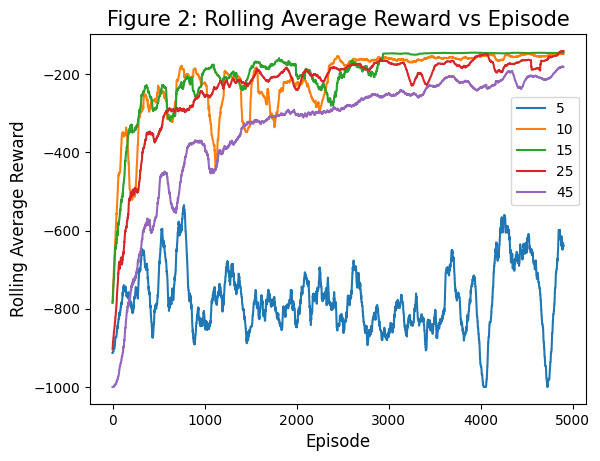

In [555]:
for b in bin_vals:
    plt.plot(bin_info[b]['smooth_rewards'],label=str(b))
plt.xlabel('Episode',size=12)
plt.ylabel('Rolling Average Reward',size=12)
plt.title('Figure 2: Rolling Average Reward vs Episode',size=15)
plt.legend( bbox_to_anchor=(1, 0.85))
plt.show()

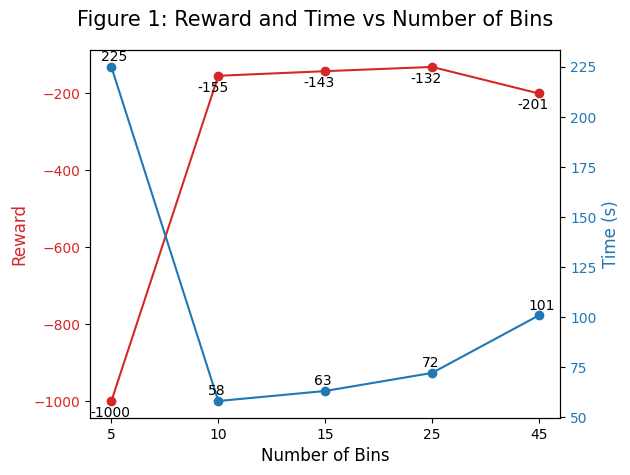

In [556]:
rewards=[bin_info[b]['rewards'][-1] for b in bin_vals]
times=[bin_info[b]['time'] for b in bin_vals]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of Bins',size=12)
ax1.set_ylabel('Reward', color=color,size=12)
plt.plot(rewards,label=str(b),color=color,marker='o')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks([i for i in range(len(bin_vals))],bin_vals)
for i, txt in enumerate(rewards):
    ax1.annotate(round(txt),(i-0.2,rewards[i]-40))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Time (s)', color=color,size=12)  # we already handled the x-label with ax1
plt.plot(times,label=str(b),color=color,marker='o')
ax2.tick_params(axis='y', labelcolor=color)
for i, txt in enumerate(times):
    ax2.annotate(round(txt),(i-0.1,times[i]+3))

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.suptitle('Figure 1: Reward and Time vs Number of Bins',size=15)
fig.tight_layout()
plt.show()

In [557]:
print(rewards)
print(bin_vals)

[-1000.0, -155.0, -143.0, -132.0, -201.0]
[5, 10, 15, 25, 45]


In [558]:
def plot_policy(Q, num_bins):
    # Prepare the grid
    position_axis = np.linspace(-1.2, 0.6, num_bins)
    velocity_axis = np.linspace(-0.07, 0.07, num_bins)
    policy_grid=np.argmax(Q, axis=2)
    # Detect states that the agent has not visited
    unvisited = np.all(Q == 0, axis=2)
    policy_grid[unvisited] = -1  # Mark unvisited states with a unique number

    # Prepare the plot
    # plt.figure(figsize=(10, 5))

    # Custom colormap: Define a color for each action, including 'unvisited'
    colors = ['dimgray', 'mediumpurple', 'white', 'mediumseagreen']  # Custom colors for 'unvisited', 'left', 'no push', 'right'
    cmap = mcolors.ListedColormap(colors)
    bounds = [-1.5, -0.5, 0.5, 1.5, 2.5]  # Boundaries for colors; ensure alignment with action values
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Plotting the policy with the custom colormap
    plt.pcolormesh(position_axis, velocity_axis, policy_grid, cmap=cmap, norm=norm, shading='auto')
    
    # Color bar and labels
    cbar = plt.colorbar(ticks=[-1, 0, 1, 2], boundaries=bounds, values=[-1, 0, 1, 2])
    cbar.ax.set_yticklabels(['Never Unvisited', 'Accelerate Left', 'No Acceleration', 'Accelerate Right'], size=12)
    plt.xlabel('Position', size=12)
    plt.ylabel('Velocity',size=12)
    plt.title(f'Figure 3: Policy obtained from num_bins: ({num_bins},{num_bins})', size=15)
    plt.tight_layout()
    plt.show()

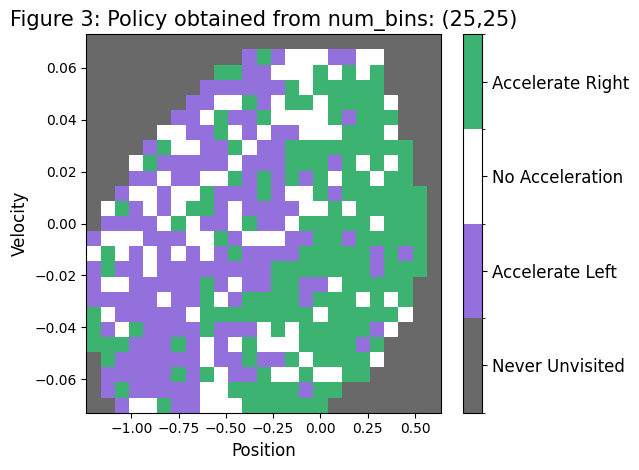

In [559]:
best_b=bin_vals[np.argmax(rewards)]

best_Q=bin_info[best_b]['Q']
policy = np.argmax(best_Q, axis=2)

plot_policy(best_Q, best_b)
